# Setting up Paths

In [1]:
#path to the data
pathCOMPASOutput = '/home/cneijssel/Documents/Projects/Data/CosmicInt/'
#path to compasrepo which contains ther popsynth folder
pathRepo = '/home/cneijssel/Documents/COMPASpop'
pathPostProcessing = '/home/cneijssel/Documents/COMPASpop/popsynth/Papers/NeijsselEtAL/PostProcessing'


# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import time
import sys
import copy
#Quick fudge to make import from ../Scripts work
import sys
sys.path.append(pathRepo + '/popsynth/Papers/NeijsselEtAL/CosmicIntegration/Scripts')
sys.path.append(pathPostProcessing+'/2_CosmicIntegration')

# Custom Imports from COMPASrepo

In [3]:
import ClassCosmicIntegrator  as CI #Given settings and redshifts returns rates (2D arrays) Loads the data
import ClassEvents            as CE
import ClassBayes             as CB
import coencodeVarious        as CV



# The cosmic integrator class

In [4]:
#Will only look at BBHs so might as well set everything
minz = 0.
maxz = 1.
resz = 50
Data = CI.CosmicIntegrator(COMPASpath = pathCOMPASOutput, DCOtypes='BBH',\
       minRedshift=minz,   maxRedshift=maxz, nrRedshiftBins=resz, optimistic=False, Cosmology='Custom Flat')

#I use the custom cosmology because this was the flatlambda prescription used before WMAP Stevenson et al 2019
#Doesnt matter to much (between WMAP and 
#this it is 22, and 22.7 per year) but to prevent redoing all the numbers in the tex for referee

print(Data.COMPAS.mass1)

Remember to  self.setCOMPASDCOmask() and self.setCOMPASData()
[44.1257 34.6308 31.6234 ... 12.792  23.9426 19.4889]


# The plot

In [5]:
#The distribution of DCOs as a function of redshift

method     = ['logNormal'                ,'MZ_GSMF'                     ,'MZ_GSMF'                      , 'MZ_GSMF']
SFRs       = ['Neijssel et al. (2019)'   ,'Madau et al. (2014)'         ,'Madau et al. (2014)'          , 'Madau et al. (2014)']
logNormal  = ['Neijssel Phenomenological', None                         , None                          , None]
GSMFs      = [None                       , 'Panter et al. (2004) Single', 'Furlong et al. (2015) Single', 'Panter et al. (2004) Single']
MZs        = [None                       , 'Langer et al. (2006)'       , 'Langer et al. (2006)'        , 'Ma et al. (2015)']

linestyles = ['-'                        , '--'                         , ':'                           , '-.']
labels     = ['Preferred model'          , 'Barrett et al. (2018) MSSFR', 'Furlong et al. (2015) Single', 'Ma et al. (2015)']


cm       = plt.get_cmap('viridis')
nColors  = 3+1  #want three colours for three variations (1 used in other plot later)
                    # dont want the brigthest colour hence I add a dummy value.
                    #Should be consistent with figure of metallicity PDFs
mycolors = [cm(x) for x in np.linspace(0,1 , nColors)]

colours  =  [ 'k'                        ,mycolors[0]                   , mycolors[1]                   , mycolors[2]]




rates    = []
totals   = []
for nrL, L in enumerate(labels):
    Data.MSSFR.Zprescription         = method[nrL]
    Data.MSSFR.SFRprescription       = SFRs[nrL]
    Data.MSSFR.logNormalPrescription = logNormal[nrL]
    Data.MSSFR.GSMFprescription      = GSMFs[nrL]
    Data.MSSFR.ZMprescription        = MZs[nrL]
    Data.cosmologicalIntegration()
        
    
    Row        =np.sum(Data.PerSystemPerRedshift_ratesObserved, axis=0)
    rates.append(Row)
    totals.extend([np.sum(Row)])
    print(L, np.sum(Row))

Preferred model 22.535488870092475
Barrett et al. (2018) MSSFR 247.87108065882057
Furlong et al. (2015) Single 441.8695636916429
Ma et al. (2015) 18.525066725772472


In [6]:
##### For each observation (column) we draw a chirpmass with probability gaussian

events     = CE.Observations() 
names, values, lowerErrors, upperErrors, survey =\
events.giveParameterAndError(parameter='Mchirp', types=['BBH'])  


draws = 5000
arraydraws = np.zeros(shape=(draws, len(names)))


Mtot       = Data.COMPAS.mChirp
bins       = np.linspace(0,60,250)
centerx     = (bins[1:]+bins[:-1])/2.
dMtot      = np.diff(bins)
gaussians  = []

Bayes      = CB.BayesianLikelyhoodSingleObservation(datapoints = Data.COMPAS.mChirp)
for nre, event in enumerate(names):
    Bayes.setObservation(observation=values[nre], lowerError=lowerErrors[nre], \
                         upperError=upperErrors[nre], confidence=0.9)
    Bayes.calculatePDFposterior()
    pdf, bins = np.histogram(Bayes._x, bins=bins, weights=Bayes._PDFobservation)
    gaussians.append(pdf)
    
    sigma   = Bayes._sigmaSymmetric
    mu      = Bayes._symmetricMu
    s = np.random.normal(mu, sigma, draws)
    arraydraws[:,nre] = s

/home/cneijssel/Documents/COMPASpop/popsynth/Papers/NeijsselEtAL/CosmicIntegration/Scripts/ClassEvents.py:59: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  boolean = (self.observations[header[nrc]] == selection).as_matrix()
/home/cneijssel/Documents/COMPASpop/popsynth/Papers/NeijsselEtAL/CosmicIntegration/Scripts/ClassEvents.py:66: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  return self.observations['eventName'].as_matrix()[boolSlice],\
/home/cneijssel/Documents/COMPASpop/popsynth/Papers/NeijsselEtAL/CosmicIntegration/Scripts/ClassEvents.py:67: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.observations[parameter].as_matrix()[boolSlice],\
/home/cneijssel/Documents/COMPASpop/popsynth/Papers/NeijsselEtAL/CosmicIntegration/Scripts/ClassEvents.py:68: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  sel

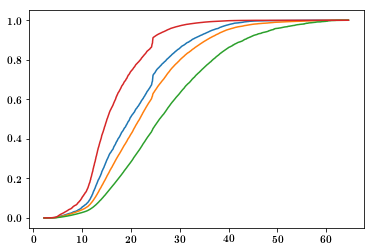

In [7]:
###### Turn each PDF into CDF per model

chirpMasses     = Data.COMPAS.mChirp
indexSortMasses = np.argsort(chirpMasses)
sortedMasses    = chirpMasses[indexSortMasses]
CDFs            = []
for nrM, model in enumerate(labels):
    sortedRate  = rates[nrM][indexSortMasses]
    CDFs.append(np.cumsum(sortedRate)/float(np.sum(sortedRate)))
fig, axes = plt.subplots(1,1)
for cdf in CDFs:
    axes.plot(sortedMasses, cdf)
plt.show()

In [8]:
def return10Masses(cdf, masses):
    #draw number between 0-1
    nrdraws = 10
    d = np.random.uniform(low=0.0, high=1.0, size=nrdraws)
    #find nearest value cdf
    indices = np.zeros(nrdraws, dtype=int)
    for nrd, draw in enumerate(d):
        difference   = np.abs(cdf-draw)
        minimum      = np.min(difference)
        indices[nrd] = int(np.where(difference == minimum)[0][0])
    indices = np.array(indices)
    return np.sort(masses[indices])

y10draws = np.cumsum(np.ones(10)/np.sum(np.ones(10)))
x10draws = []
counter  = 0
while counter < draws:
    masses = return10Masses(CDFs[0], sortedMasses)
    x10draws.append(masses)
    counter+=1
    
print(len(x10draws))

5000


In [9]:
fig        = plt.subplots(1,1,figsize=(9,14))
ax0        = plt.subplot2grid((6,3),(0,0), colspan=3, rowspan=3)
ax1        = plt.subplot2grid((6,3),(3,0), colspan=3, rowspan=3)

ax12 = ax1.twinx() #right side bottom panel for cumulative

############
#  Top panel with MSSFR
############
Mtot       = Data.COMPAS.mChirp
bins       = np.linspace(0,60,100)
center     = (bins[1:]+bins[:-1])/2.
dMtot      = np.diff(bins)

for nrL, L in enumerate(labels):
    rate       = rates[nrL]
    rate, _    = np.histogram(Mtot, bins=bins, weights = rate)
    rate       = np.divide(rate, dMtot)
    rate       = rate / np.sum(rate)
    label      = labels[nrL]+r' $\rm \normalfont [%s \ yr^{-1}]$' %(int(totals[nrL]))
    ax0.plot(center, rate, lw=3.5, c=colours[nrL], label=label, linestyle=linestyles[nrL], alpha=0.85)
ax0.get_xaxis().set_visible(False)
nameX = r'$  $'
nameY = r'$\rm dP / dM_{chirp} \ [M_{\odot}^{-1}]  $'
ax0 = CV.layoutAxes(ax0, nameX=nameX, nameY=nameY)
ax0.legend(loc=1, prop={'size':16})
ax0.set_ylim(top=0.07)


##########
#
#########

for nrd  in range(draws):
    ax1.plot(x10draws[nrd], y10draws, lw=1., c=colours[0], alpha=.05)
###########
# Bottom panel with Events
###########
for nre, event in enumerate(names):
    for nrd  in range(draws):
        #row is random draw sort them on chirpmass
        chirpmasses = np.sort(arraydraws[nrd])
        cumulative  = np.cumsum(np.ones(len(chirpmasses)))/float(len(chirpmasses))
        ax1.plot(chirpmasses, cumulative, lw=1., c='c', alpha=0.1)
        
    print(len(centerx), len(gaussians[nre]))
    ax12.plot(centerx, gaussians[nre], lw=2., c='c')
    
#for nrL, L in enumerate(labels):
#    rate       = rates[nrL]
#    ax1.plot(center, np.cumsum(rate)/float(np.sum(rate)), c=colours[nrL], linestyle=linestyles[nrL],\
#              alpha=0.85,lw=3.5)

    
ax12.set_xlim(ax0.get_xlim())
ax1.set_xlim(ax0.get_xlim())
ax1.set_ylim(top=1.01)
y = ax1.get_yticks()
ax1.set_yticks(y[:-2])
ax12.set_ylim(top=0.8)
ax12.get_yaxis().set_visible(False)
nameX = r'$\rm M_{chirp}\ \ [M_{\odot}] $'
nameY = r'$\rm CDF $'
ax1 = CV.layoutAxes(ax1, nameX=nameX, nameY=nameY)
ax12 = CV.layoutAxes(ax12, nameX='', nameY='', second=True)
plt.tight_layout()
plt.subplots_adjust(wspace=0., hspace=0.0)
plt.savefig('./MassDistributionAtRedshiftObs.png', dpi=300, transparent=False)
#plt.show()
plt.close()

249 249
249 249
249 249
249 249
249 249
249 249
249 249
249 249
249 249
249 249
